# Making a Map

First off, let's just test PySM3. We'll simulate a single component and show it using healpy.

In [1]:
import pysm3
import pysm3.units as u
import matplotlib.pyplot as plt
import healpy as hp

Basic parameters for these simulations are 
- `nside`: The map resolution
- `preset_strings`: The contaminants to add
- The frequency at which we simulation observation (here, `freq`)

In [2]:
_nside = 128
_preset_strings = ["s4"]
_freq = 100 * u.GHz
_map_range = (10,25)  # Set intensity range so we can make visual comparisons

In [3]:
def make_map(nside, preset_strings, freq):
    # Build the model
    sky = pysm3.Sky(nside=nside, preset_strings=preset_strings)
    # Simulate the radiation from this sky at a particular frequency
    skymap = sky.get_emission(freq)
    return skymap

In [4]:
def show_a_map(skymap, title, field_idx=0, **kwargs):
    hp.mollview(skymap[field_idx], min=_map_range[0], max=_map_range[1], title=title)
    plt.show()

In [5]:
def show_temperature_map(nside=_nside, preset_strings=_preset_strings, freq=_freq):
    skymap = make_map(nside, preset_strings, freq)
    show_a_map(skymap, title=f"Temperature Map, Frequency {int(freq.value)} GHz")

Now we can view that output.

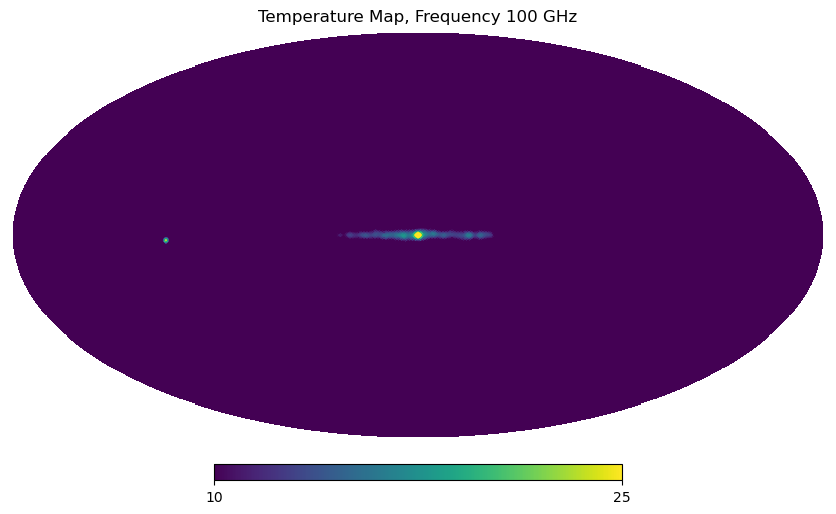

In [6]:
show_temperature_map(preset_strings=["s4"])

Multiple contaminants can be assembled for a single map.

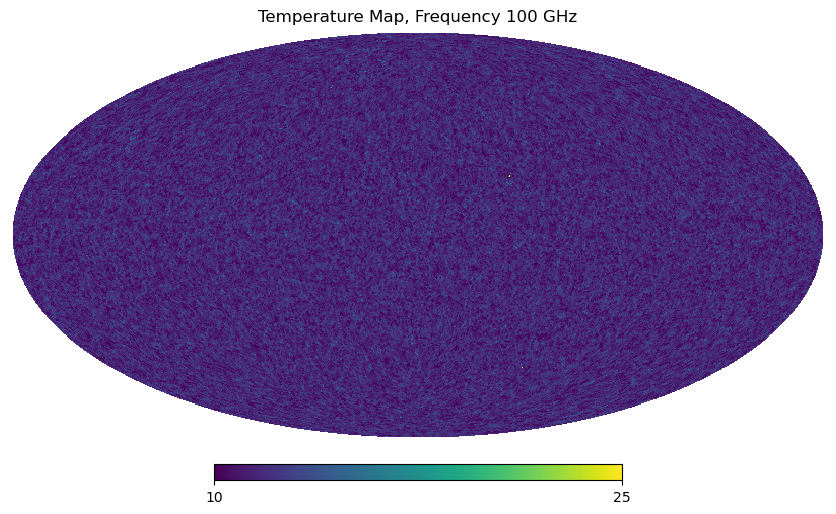

In [7]:
show_temperature_map(preset_strings=["cib1"])

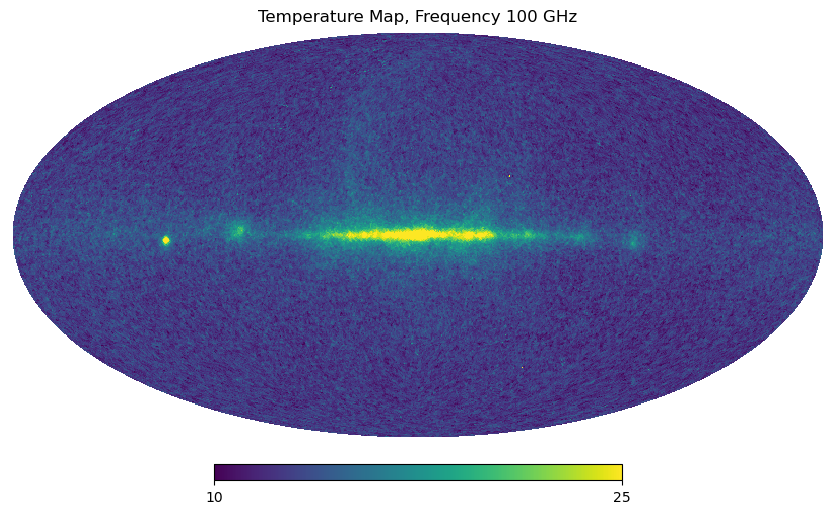

In [8]:
show_temperature_map(preset_strings=["cib1", "s4"])

# Components

There are a bunch of components currently implemented in PySM3. Many options, the range of which is given.

- c#:    [1- 4]  cmb
- d#:    [1-12]  dust
- s#:    [1- 7]  synchrotron
- a#:    [1- 2]  ame
- f#:    [1]     free-free
- co#:   [1- 3]  CO line Emission
- cib#:  [1]     Cosmic Infrared Background
- tsz#:  [1]     Thermal Sunyaev-Zeldovich
- ksz#:  [1]     Kinetic Sunyaev-Zeldovich
- rg#:   [1]     Radio Galaxies

There are prescribed sets of the contaminants, for varied levels of complexity of the simulations. The group that put this together is focused on Galactic signal, so they are only for those components.

[Common Fiducial Sky for CMB Experiments](https://galsci.github.io/blog/2022/common-fiducial-sky/)

- Low complexity: `d9,s4,f1,a1,co1`
- Medium complexity: `d10,s5,f1,a1,co3`
- High complexity: `d12,s7,f1,a2,co3`

There's only a single version of each extragalactic component, so we simply use those.

[Common fiducial sky for CMB experiments, Extragalactic and CMB](https://galsci.github.io/blog/2022/common-fiducial-extragalactic-cmb/)

- Extragalactic: `cib1, tsz1, ksz1, rg1`
- CMB Parameters:
  - $\Omega_b = 0.049$
  - $\Omega_c = 0.261$
  - $\Omega_m = \Omega_b + \Omega_c$
  - $h = 0.68$
  - $n_s = 0.965$
  - $A_s = 2.022e^{-9}$
  - $\tau = 0.055$

Details on all components can be found in the pysm3/data/presets.cfg file, visible either at [PySM3's GitHub](https://github.com/galsci/pysm/blob/main/pysm3/data/presets.cfg) or the output of the following cell: 

In [9]:
import pysm3
from pathlib import Path
print(Path(pysm3.__path__[0]) / "data" / "presets.cfg")

/home/jim/miniconda3/envs/pysm_env/lib/python3.8/site-packages/pysm3/data/presets.cfg


Each component requires various data assets. It's on the order of ~60 GB of data, so I'll skip producing maps from all of these needlessly.

# Detectors

As mentioned earlier, we simulate the emission of all components at a particular frequency. The frequencies chosen match those of the Planck Mission detectors. Contaminants, because they are caused by different phenomena, are relatively dimmer than others at certain frequencies.

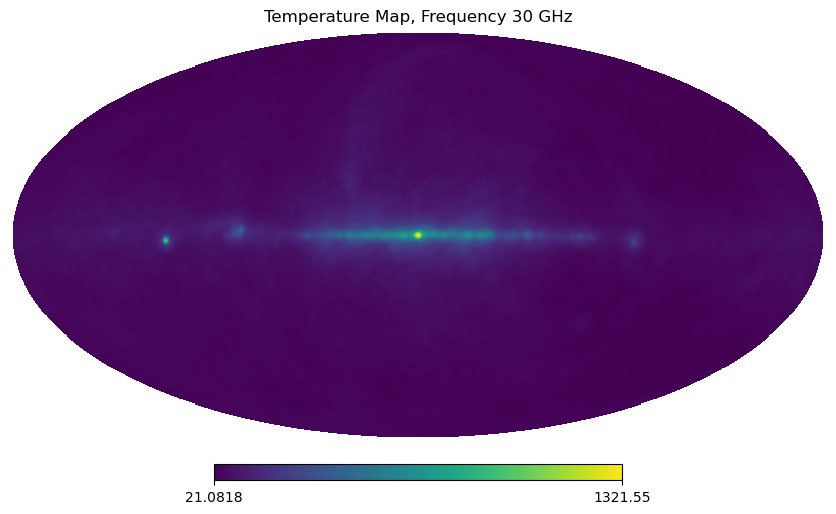

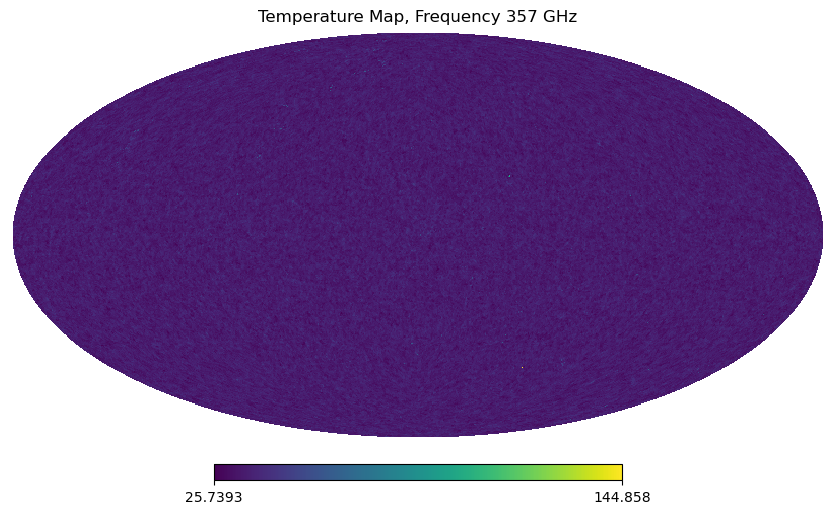

In [10]:
_map_range = (None, None)  # Allow intensity range to be set by signal displayed
show_temperature_map(preset_strings=["cib1", "s4"], freq=30*u.GHz)   # At  30 GHz
show_temperature_map(preset_strings=["cib1", "s4"], freq=357*u.GHz)  # At 357 GHz

Note that, though there is variation in the *spectral* domain, there should be no variation in the *spatial* domain. In the following plots, note that the splotches in the oval are in the same position, and only the scale changes.

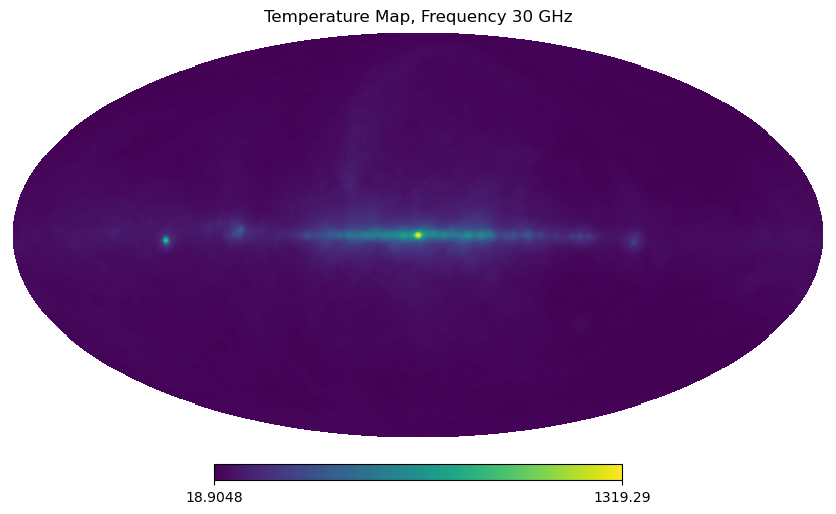

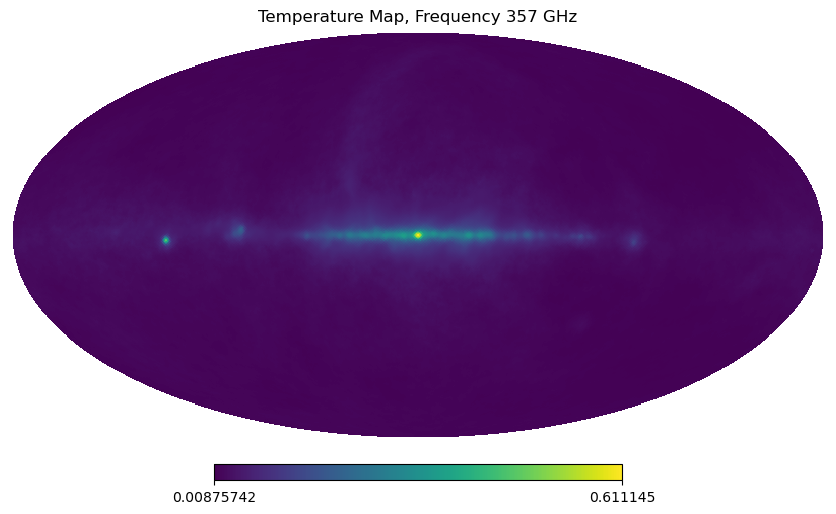

In [11]:
_map_range = (None, None)  # Allow intensity range to be set by signal displayed
show_temperature_map(preset_strings=["s4"], freq=30*u.GHz)
show_temperature_map(preset_strings=["s4"], freq=357*u.GHz)

# Beam Effects and Noise

Because no detector is perfect, we have to also consider beam smoothing and signal noise. 

Beam smoothing occurs because a detector sees a small region of space, not a single point. Signal noise has many sources throughout the system, despite all the engineering effort to reduce it.

In the simulation, we use PySM3's `apply_smoothing_and_coord_transform` to do this. It involves matrix inversions, so it can be a relatively slow process.

In [12]:
_map_range = (10,25)  # Set the intensity range so that we can make visual comparisons

In [13]:
def make_map(nside, preset_strings, freq):
    # Build the model
    sky = pysm3.Sky(nside=nside, preset_strings=preset_strings)
    # Simulate the radiation from this sky at a particular frequency
    skymap = sky.get_emission(freq)

    # Smooth the map
    fwhm_degrees = 2*u.deg  # Full width at half maximum in degrees, arbitrary large value for emphasis
    map_smoothed = pysm3.apply_smoothing_and_coord_transform(
                            skymap, fwhm=fwhm_degrees)

    return map_smoothed

Map with smoothing:

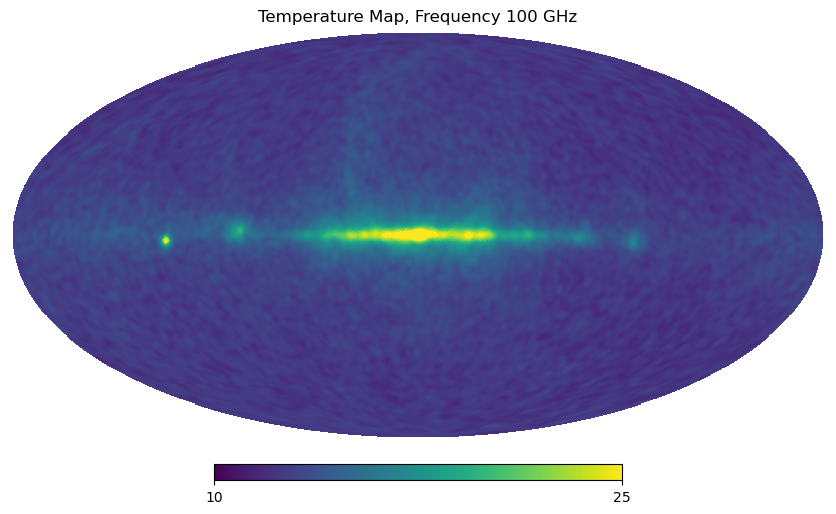

In [14]:
show_temperature_map(preset_strings=["cib1", "s4"])

We can also apply instrumentation noise. This is due to random fluctuations in the electronics of the instruments making measurements. The following demonstration assumes that the randomness is the same in all directions. We will refine this soon.

Note that noise is added after beam effects.

In [15]:
import numpy as np

def make_map(nside, preset_strings, freq):
    # Build the model
    sky = pysm3.Sky(nside=nside, preset_strings=preset_strings)
    # Simulate the radiation from this sky at a particular frequency
    skymap = sky.get_emission(freq)

    # Imaginary detector
    fwhm_degrees = 2*u.deg  # Full width at half maximum in degrees, arbitrary large value for emphasis
    map_smoothed = pysm3.apply_smoothing_and_coord_transform(
                            skymap, fwhm=fwhm_degrees)
    
    # Add Gaussian noise (poorly)
    npix = hp.nside2npix(nside)
    noise_std = 0.5  # Adjust this value for noise level
    noise = np.random.normal(0, noise_std, (3, npix)) * skymap.unit

    return map_smoothed + noise

Map with smoothing and noise:

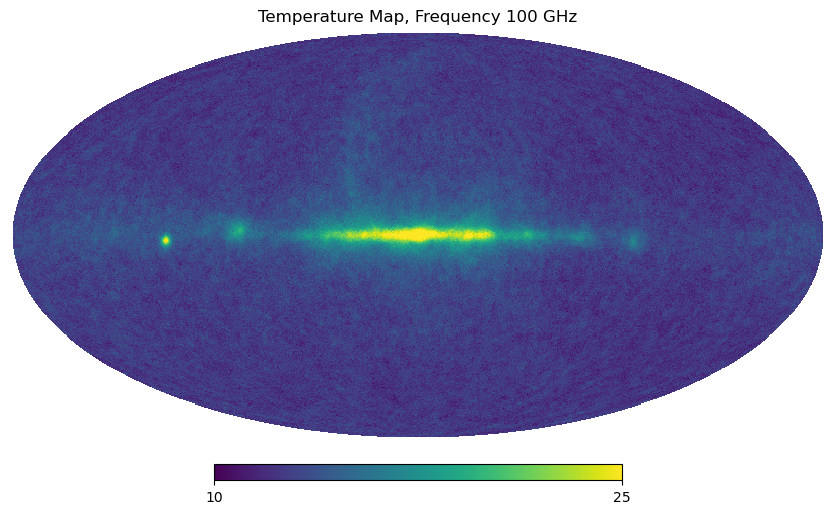

In [16]:
show_temperature_map(preset_strings=["cib1", "s4"])

# Better Beam Effects

The beam effects depend on the detection frequency of the instrument making a measurement. In general, the lower frequency instruments have wider apertures, causing more blurring. (Note, check on this)

The Planck Mission instruments were well characterized, so these are known to good precision (though the characterization of beams for other missions can be much more sophisticated). I'm using a relatively coarse characterization, from a table included in the PySM3 archive. There are other models which are more sophisticated (the RIMO, for instance). I don't know how to use them currently, so this will have to suffice.

The term "full-width at half-maximum" (fwhm) characterizes a detector beam. It describes especially how close signals can be (spatially) when the detector begins to pick up both at the same time. A better descriptions is [here](https://en.wikipedia.org/wiki/Full_width_at_half_maximum).

Note that I'll also use the true center frequency of the beam. For instance, the beam referred to as 353 GHz actually detects signals at 357.5 GHz with greatest sensitivity.

Also, Physics Folks, note that the characterization (planck_deltabandpass.tbl) gives parameters per detection frequency, not individual detectors. I am not confident in these values being applied to the polarization data.

I have to start using Hydra for configuration settings. For now, disregard any lines with the following: `initialize`, `compose`.

In [17]:
from hydra import initialize, compose

from planck_instrument import PlanckInstrument, make_planck_instrument

_freqs = [30, 100, 353]
_map_range = [None, None]  # Allow intensity range to be set by signal displayed

In [18]:
def make_beam_effect_maps(nside=_nside, preset_strings=_preset_strings, freqs=_freqs, view="mollview"):
    sky = pysm3.Sky(nside=nside, preset_strings=preset_strings)
    
    # Instrument parameters
    with initialize(version_base=None, config_path="cfg"):
        cfg = compose(config_name="config_no_out.yaml", 
                      overrides=["local_system=jim_lab.yaml"])
        planck: PlanckInstrument = make_planck_instrument(cfg)

    for freq in freqs:
        skymap = sky.get_emission(planck.detectors[freq].cen_freq)

        # Full-width, half-max describes the shape of a beam
        fwhm = planck.detectors[freq].fwhm

        map_smoothed = pysm3.apply_smoothing_and_coord_transform(skymap, fwhm=fwhm)
        show_a_map(map_smoothed, title=f"Temperature Map of {' '.join(preset_strings)} at {freq} GHz with Beam Effects", view=view)

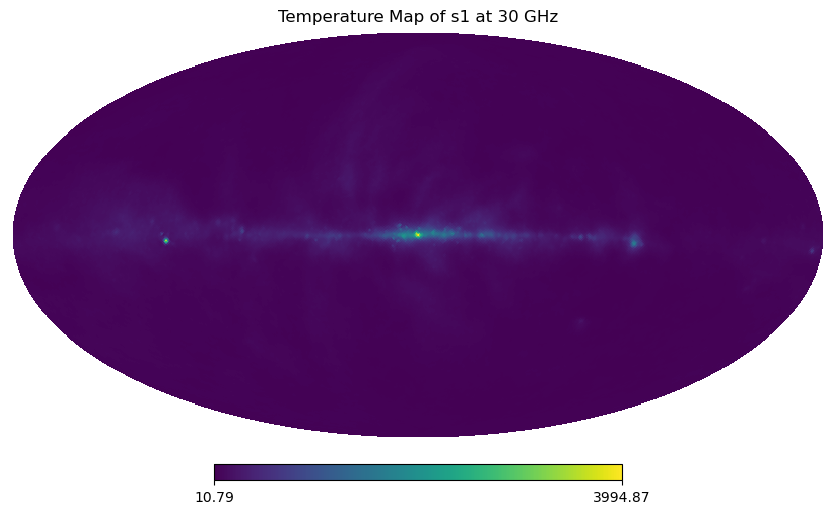

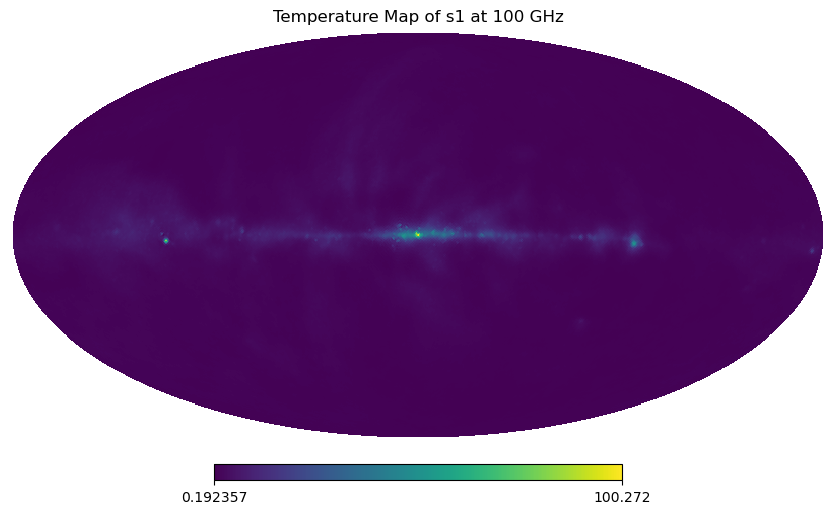

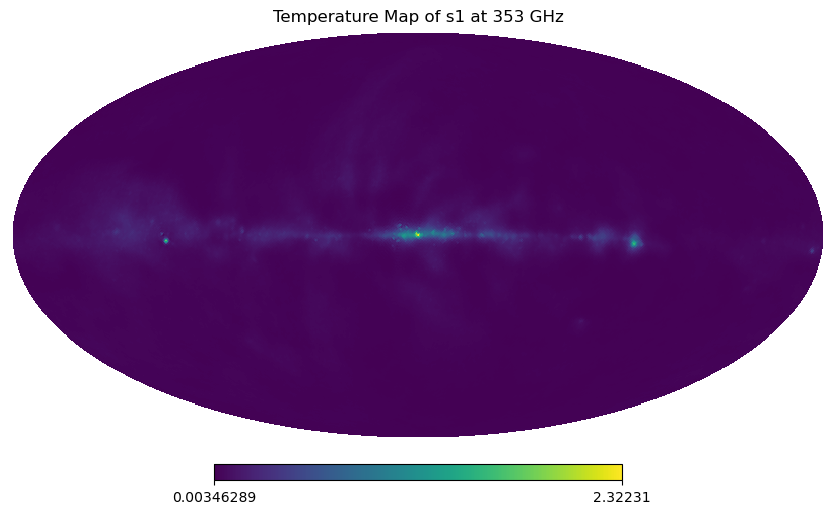

In [19]:
make_beam_effect_maps(preset_strings=["s1"], freqs=_freqs)

You're not seeing anything strange: it's really tough to see the differences at the resolutions we're using. We can use a different view to better see the effect, by using a higher resolution and zooming in on a small patch of the sky.

In [20]:
def show_a_map(skymap, title, field_idx=0, view="mollview"):
    if view == "gnomview":
        hp.gnomview(skymap[field_idx], min=_map_range[0], max=_map_range[1], xsize=800, title=title)
    else:
        hp.mollview(skymap[field_idx], min=_map_range[0], max=_map_range[1], title=title)
    plt.show()

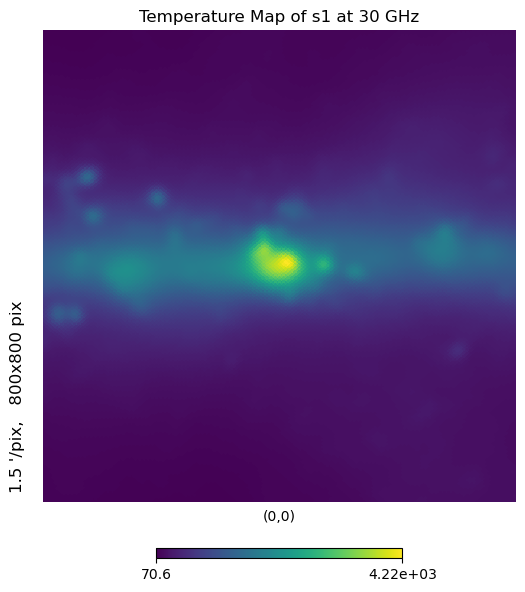

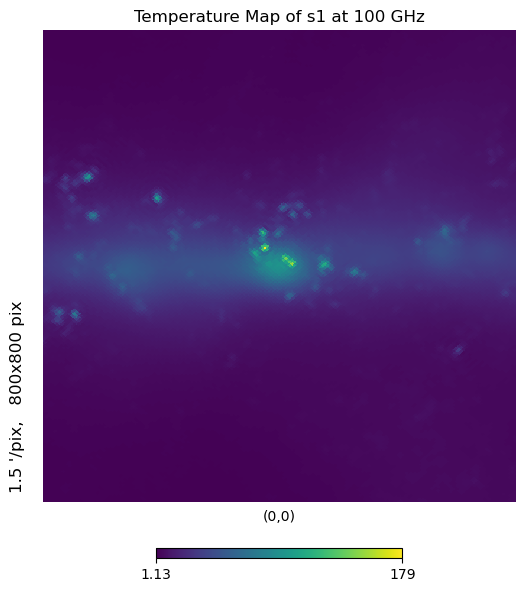

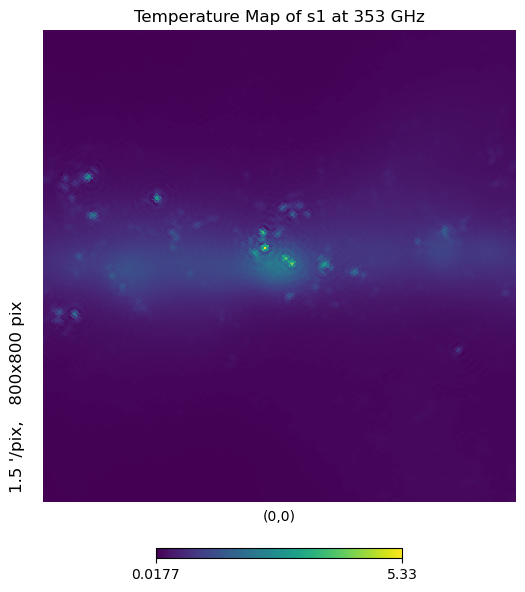

In [21]:
make_beam_effect_maps(nside=512, preset_strings=["s1"], freqs=_freqs, view="gnomview")

That's better! The fwhm of the 100 GHz detector is only different from that of the 353 GHz detector by a factor of 2, yet it's visible.

While it's there, note that there are ripples around the bright points in the 353 GHz map. That's called "ringing" and is fixed a couple different ways. I don't yet know how to fix it. While looks like an [Airy disc](https://en.wikipedia.org/wiki/Airy_disk), it's more similar to the ripples at the corners of a Fourier-transformed step function. It's caused by some combination of the resolution settings, the detector fwhm, and the mathematical transformations involved in scaling the map.

# Better Noise Effects

The noise effects are also a function of the detectors used.

We have some information on the Planck collaborations estimates of the signal noise. There are many versions of it; I've simply chosen something that seems reasonably accurate, capturing intrinsic variations. It was also relatively easy to implement.

In [22]:
from planck_instrument import InstrumentNoiseMaker, InstrumentNoise

In [23]:
def make_beam_and_noise_maps(nside=_nside, preset_strings=_preset_strings, freqs=_freqs, view="mollview"):
    sky = pysm3.Sky(nside=nside, preset_strings=preset_strings)
    
    # Instrument parameters
    with initialize(version_base=None, config_path="cfg"):
        cfg = compose(config_name="config_no_out.yaml", 
                      overrides=["local_system=jim_lab.yaml"])
        planck: PlanckInstrument = make_planck_instrument(cfg)
        noise_maker = InstrumentNoiseMaker(cfg, planck)

    noise: InstrumentNoise = noise_maker.make_instrument_noise()

    for freq in freqs:
        detector = planck.detectors[freq]
        skymap = sky.get_emission(detector.cen_freq)

        fwhm = planck.detectors[freq].fwhm
        map_smoothed = pysm3.apply_smoothing_and_coord_transform(skymap, fwhm=fwhm)
        
        noise_map = noise.get_noise_map(freq, field="T", seed=0)

        final_map = map_smoothed + noise_map

        show_a_map(final_map, title=f"Temperature Map of {' '.join(preset_strings)} at {freq} GHz with Beam Effects and Noise", view=view)

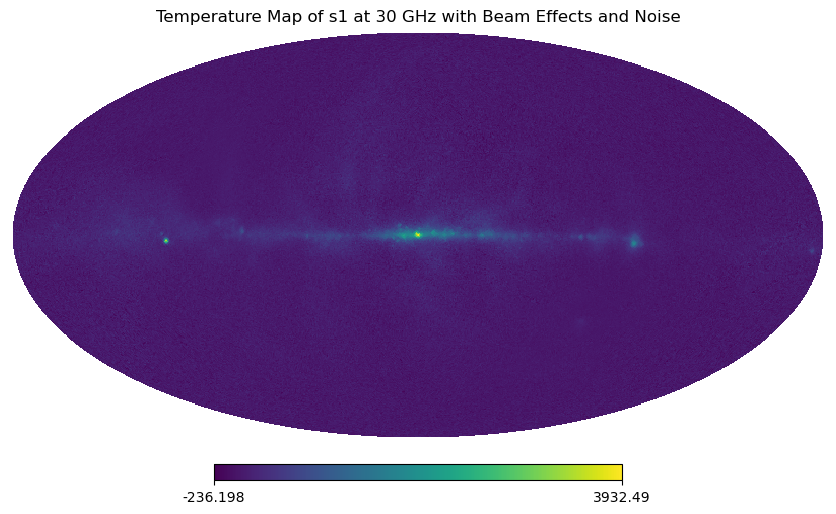

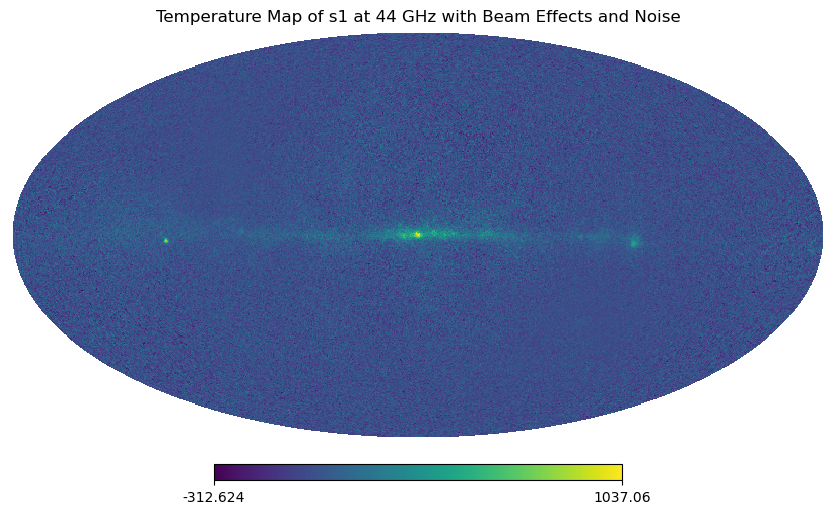

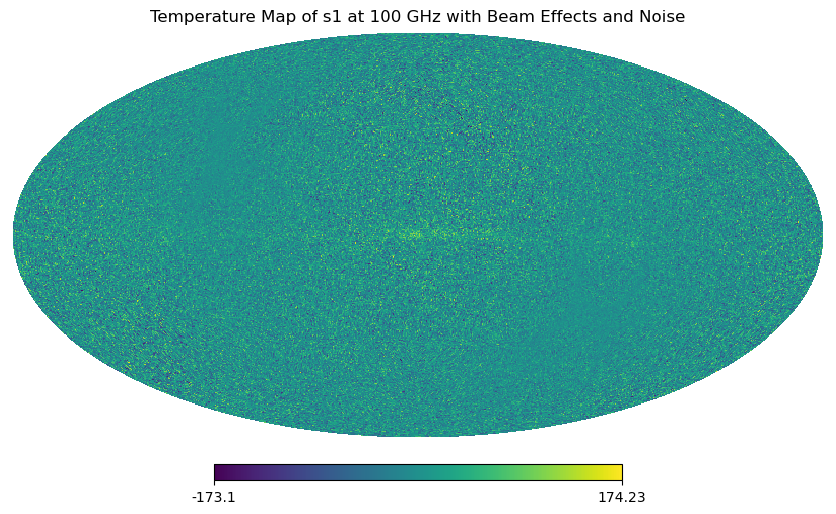

In [26]:
make_beam_and_noise_maps(preset_strings=["s1"], freqs=[30, 44, 100])

Remember that we're looking at a single component of the sky. Synchrotron radiation is dominated by noise at higher frequencies.

# CMB

Now let's look at the CMB. This is not precisely how it looks elsewhere in the code. Elsewhere, we have prepared to run Monte Carlo simulations, and will keep the power spectra. Here we disregard it and use the `tempfile` library to ensure it's well cleaned-up.

In [27]:
import tempfile

from component_cmb import make_cmb_ps

In [37]:
def make_cmb_map(nside=_nside, freqs=_freqs, view="mollview"):
    with initialize(version_base=None, config_path="cfg"):
        cfg = compose(config_name="config_no_out.yaml", 
                      overrides=["local_system=jim_lab.yaml"])
        planck: PlanckInstrument = make_planck_instrument(cfg)
    
    cosmo_params = dict(H0=68, 
                        ombh2=0.02266, 
                        omch2=0.12069, 
                        tau=0.055,
                        ns=0.965)
    lmax = 8150

    # Disregard the details of the tempfile library.
    with tempfile.NamedTemporaryFile(mode='w+', delete=True) as temp_file:
        make_cmb_ps(cosmo_params, lmax, temp_file)
        cmb = pysm3.CMBLensed(nside=nside,
                              cmb_spectra=temp_file.name,
                              cmb_seed=0)

    sky = pysm3.Sky(nside=nside, component_objects=[cmb])

    for freq in freqs:
        detector = planck.detectors[freq]
        skymap = sky.get_emission(detector.cen_freq)
        fwhm = planck.detectors[freq].fwhm
        map_smoothed = pysm3.apply_smoothing_and_coord_transform(skymap, fwhm=fwhm)
        show_a_map(map_smoothed, title=f"Temperature Map of CMB at {freq} GHz", view=view)

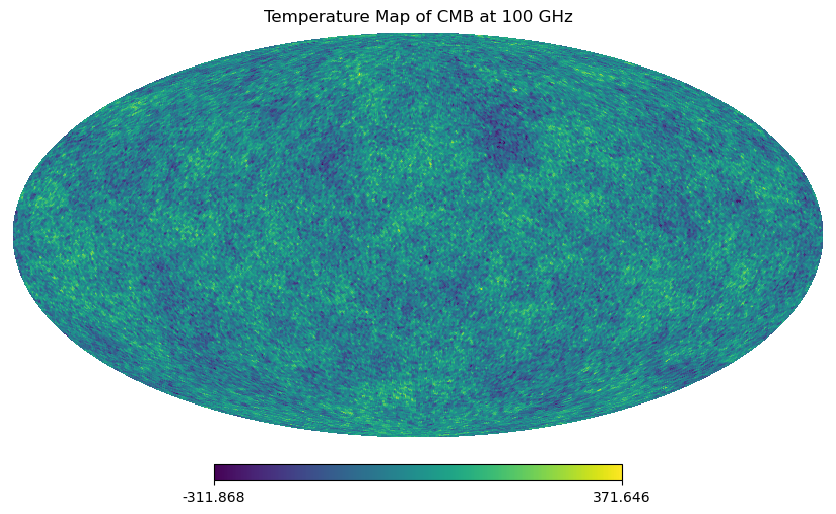

In [38]:
make_cmb_map(nside=128, freqs=[100])

# Fields

So far, I've referred to different components and detectors. However, at each frequency each component gives off light with different characteristics. This is known as the polarization of the light: it may be unpolarized or polarized in one of two orthogonal ways. So far we've looked at the "Temperature" maps, which ignores the polarization of the signal. We could also look at the "Q" or "U" polarized signal.

For instance, let's look at Synchrotron radiation at 100 GHz.

In [35]:
def show_fields_maps(nside=_nside, preset_strings=_preset_strings, freq=_freq):
    # Build the model
    sky = pysm3.Sky(nside=nside, preset_strings=preset_strings)
    # Simulate the radiation from this sky at a particular frequency
    skymap = sky.get_emission(freq*u.GHz)

    for field_idx in range(3):
        field_str = 'TQU'[field_idx]
        title=f"Field {field_str} Map of {', '.join(preset_strings)} at {freq} GHz"
        hp.mollview(skymap[field_idx], min=_map_range[0], max=_map_range[1], title=title)

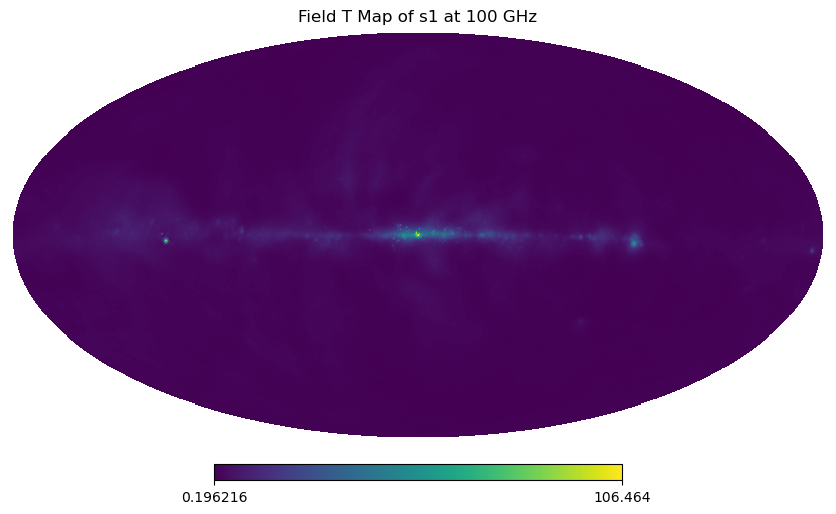

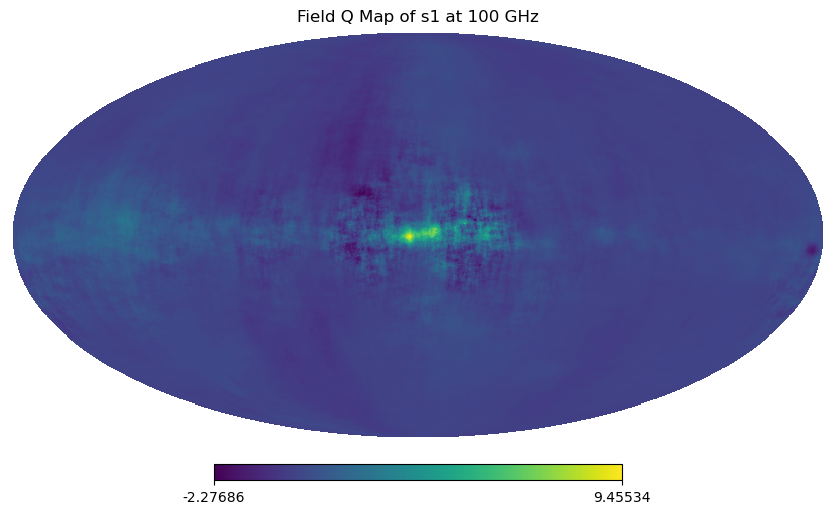

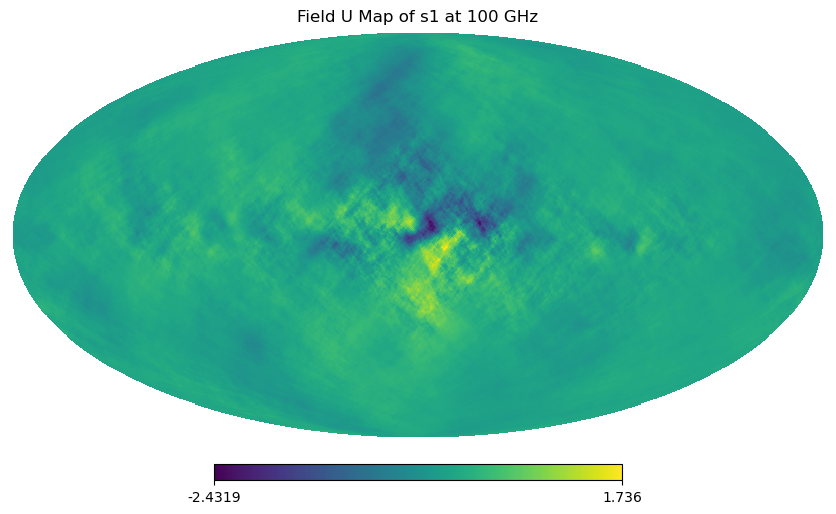

In [36]:
show_fields_maps(nside=128, preset_strings=["s1"], freq=100)

# All Together Now

We'll combine everything above into a more realistic simulation.

In [48]:
plot_intensity_ranges = {'T': (None, None), 'Q': (None, None), 'U': (None, None)}

def make_nice_maps(nside=_nside, preset_strings=_preset_strings, freqs=_freqs, fields='TQU', cmap=None):
    
    # Instrument parameters
    with initialize(version_base=None, config_path="cfg"):
        cfg = compose(config_name="config_no_out.yaml", 
                      overrides=["local_system=jim_lab.yaml"])
        planck: PlanckInstrument = make_planck_instrument(cfg)
        noise_maker = InstrumentNoiseMaker(cfg, planck)

    cosmo_params = dict(H0=68, 
                        ombh2=0.02266, 
                        omch2=0.12069, 
                        tau=0.055,
                        ns=0.965)
    lmax = 8150

    # Disregard the details of the tempfile library.
    with tempfile.NamedTemporaryFile(mode='w+', delete=True) as temp_file:
        make_cmb_ps(cosmo_params, lmax, temp_file)
        cmb = pysm3.CMBLensed(nside=nside,
                              cmb_spectra=temp_file.name,
                              cmb_seed=0)

    sky = pysm3.Sky(nside=nside, preset_strings=preset_strings, component_objects=[cmb])
    noise: InstrumentNoise = noise_maker.make_instrument_noise()

    for freq in freqs:
        detector = planck.detectors[freq]
        skymap = sky.get_emission(detector.cen_freq)

        fwhm = planck.detectors[freq].fwhm
        map_smoothed = pysm3.apply_smoothing_and_coord_transform(skymap, fwhm=fwhm)
        
        noise_map = noise.get_noise_map(freq, field="T", seed=0)

        final_map = map_smoothed + noise_map

        for field_idx, field_str in enumerate(fields):
            map_range = plot_intensity_ranges[field_str]
            title = f"Simulation of {', '.join(preset_strings)} and CMB at {freq} GHz, {field_str} field, with Beam Effects and Noise"
            hp.mollview(final_map[field_idx], min=map_range[0], max=map_range[1], title=title, cmap=cmap)


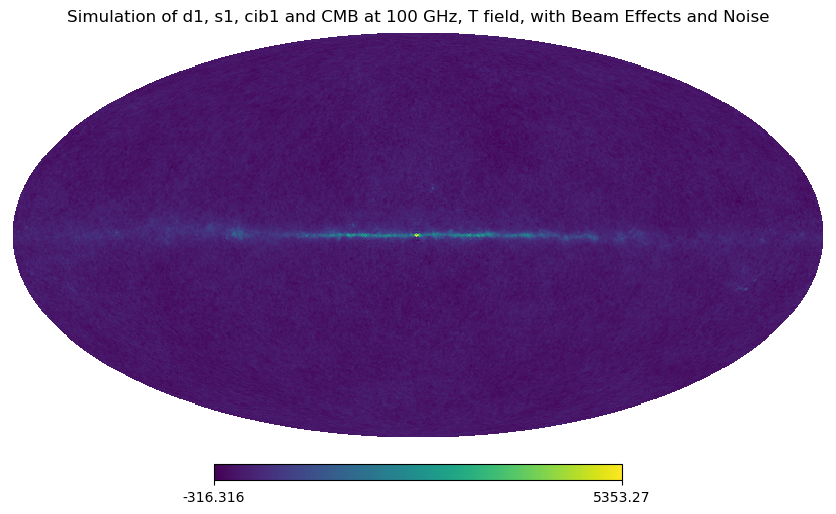

In [43]:
make_nice_maps(nside=128,
               preset_strings=["d1", "s1", "cib1"],
               freqs=[100],
               fields='T')

That looks pretty good! As a finisher, let's look at all fields for this map and use the official Planck coloring scheme (including intensity ranges) so we look totally legit!

In [44]:
from matplotlib.colors import ListedColormap
from planck_cmap import colombi1_cmap

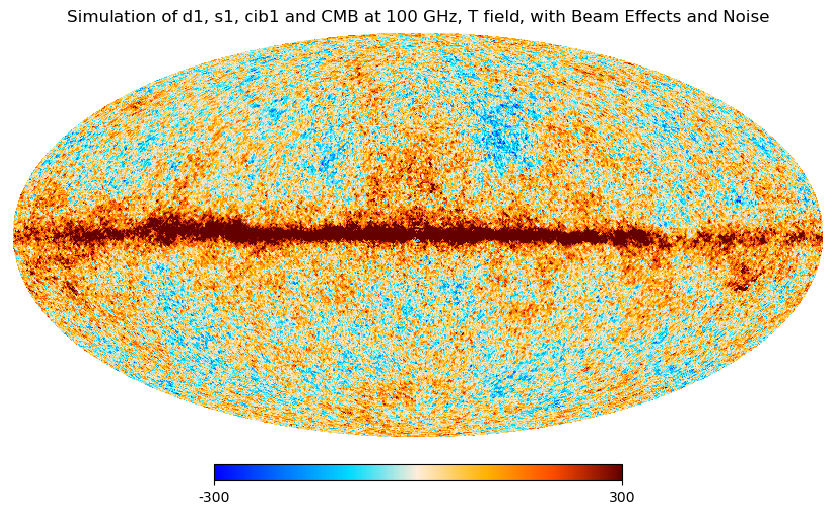

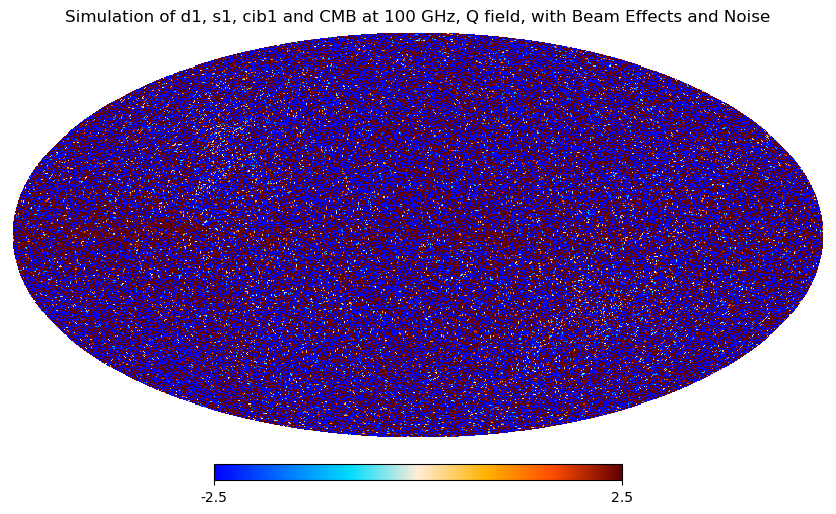

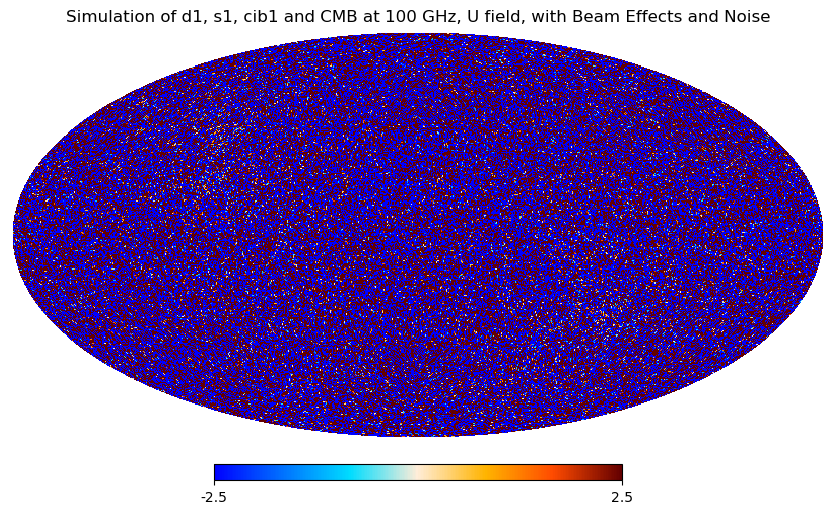

In [50]:
plot_intensity_ranges = {'T': (-300, 300), 'Q': (-2.5, 2.5), 'U': (-2.5, 2.5)}

make_nice_maps(nside=128,
               preset_strings=["d1", "s1", "cib1"],
               freqs=[100],
               fields='TQU',
               cmap=colombi1_cmap)

Uh oh! That's not so legit. I guess we've got work to do...